# First NN to test a simple model

In this notebook, we implement a simple neural network to predict the photovoltaic power generation. We use the data from the University of Liege.

### import libraries

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader

import wandb

In [2]:
DATA_PATH = 'data/cleaned.csv'

In [3]:
df = pd.read_csv('data/cleaned.csv', sep=';',  parse_dates=[0])
df.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
df['date'] = pd.to_datetime(df['date'])
df

,date,id,Power_1,Power_2,Power_3,Power_4,Power_5,Power_6,Power_7,Power_8,...,CU,CM,CD,TT2M,ST,RH2m,WS10m,WS100m,PREC,SNOW
0,2022-01-01 02:15:00+02:00,577035.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,8.38,8.38,93.34,3.46,9.10,0.0,0.0
1,2022-01-01 02:30:00+02:00,577038.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,8.52,8.52,92.18,3.81,9.52,0.0,0.0
2,2022-01-01 02:45:00+02:00,577041.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,8.66,8.66,90.91,4.15,9.66,0.0,0.0
3,2022-01-01 03:00:00+02:00,577044.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,8.76,8.76,90.18,4.36,9.50,0.0,0.0
4,2022-01-01 03:15:00+02:00,577047.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,8.74,8.74,90.39,4.38,9.16,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28845,2022-12-31 21:30:00+02:00,667201.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.76,0.0,0.0,13.14,13.14,72.48,7.39,13.79,0.0,0.0
28846,2022-12-31 21:45:00+02:00,667204.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.00,0.0,0.0,13.13,13.13,72.07,7.46,13.93,0.0,0.0
28847,2022-12-31 22:00:00+02:00,667207.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.00,0.0,0.0,13.12,13.12,71.67,7.52,14.04,0.0,0.0
28848,2022-12-31 22:15:00+02:00,667210.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.00,0.0,0.0,13.10,13.10,71.36,7.55,14.10,0.0,0.0


In [4]:
col_to_keep = ['Power_Total','date' ,'SWD', 'SWDtop', 'CU', 'CM', 'CD', 'TT2M', 'ST', 'RH2m', 'WS10m', 'WS100m', 'PREC', 'SNOW']
df = df.loc[:,col_to_keep]
df.dropna(inplace=True)
df.head()

,Power_Total,date,SWD,SWDtop,CU,CM,CD,TT2M,ST,RH2m,WS10m,WS100m,PREC,SNOW
0,0.0,2022-01-01 02:15:00+02:00,0.0,0.0,0.0,0.0,0.0,8.38,8.38,93.34,3.46,9.10,0.0,0.0
1,0.0,2022-01-01 02:30:00+02:00,0.0,0.0,0.0,0.0,0.0,8.52,8.52,92.18,3.81,9.52,0.0,0.0
2,0.0,2022-01-01 02:45:00+02:00,0.0,0.0,0.0,0.0,0.0,8.66,8.66,90.91,4.15,9.66,0.0,0.0
3,0.0,2022-01-01 03:00:00+02:00,0.0,0.0,0.0,0.0,0.0,8.76,8.76,90.18,4.36,9.50,0.0,0.0
4,0.0,2022-01-01 03:15:00+02:00,0.0,0.0,0.0,0.0,0.0,8.74,8.74,90.39,4.38,9.16,0.0,0.0


In [5]:
#split the column date into month, day, hour, minutes
df['month'] = df['date'].apply(lambda x: x.month)
df['day'] = df['date'].apply(lambda x: x.day)
df['hour'] = df['date'].apply(lambda x: x.hour)
df['minutes'] = df['date'].apply(lambda x: x.minute)
df.drop(columns=['date'], inplace=True)
df.head()

,Power_Total,SWD,SWDtop,CU,CM,CD,TT2M,ST,RH2m,WS10m,WS100m,PREC,SNOW,month,day,hour,minutes
0,0.0,0.0,0.0,0.0,0.0,0.0,8.38,8.38,93.34,3.46,9.10,0.0,0.0,1,1,2,15
1,0.0,0.0,0.0,0.0,0.0,0.0,8.52,8.52,92.18,3.81,9.52,0.0,0.0,1,1,2,30
2,0.0,0.0,0.0,0.0,0.0,0.0,8.66,8.66,90.91,4.15,9.66,0.0,0.0,1,1,2,45
3,0.0,0.0,0.0,0.0,0.0,0.0,8.76,8.76,90.18,4.36,9.50,0.0,0.0,1,1,3,0
4,0.0,0.0,0.0,0.0,0.0,0.0,8.74,8.74,90.39,4.38,9.16,0.0,0.0,1,1,3,15


In [6]:
class TriplePs(Dataset):
    def __init__(self, data, test = False, test_size = 0.2, seed=42):
        self.data = data
        self.nb_input = len (data.columns) - 1
        self.input = data.iloc[:, 1:]
        self.output = data.iloc[:, 0]
        self.test = test
        self.train_size = 1-test_size

        self.seed = seed
        np.random.seed(seed)

        self.idx = np.arange(len(data))
        np.random.shuffle(self.idx)
        self.train_idx = self.idx[:int(len(self.idx)*self.train_size)]
        self.test_idx = self.idx[int(len(self.idx)*self.train_size):]

        #convert to tensor
        self.input = torch.tensor(self.input.values, dtype=torch.float32)
        self.output = torch.tensor(self.output.values, dtype=torch.float32)

        if self.test:
            self.input = self.input[self.test_idx]
            self.output = self.output[self.test_idx]
        else:
            self.input = self.input[self.train_idx]
            self.output = self.output[self.train_idx]


    def __len__(self):
        return len(self.input)
    
    def __getitem__(self, idx):
        return self.input[idx], self.output[idx]
    


In [7]:
trainset = TriplePs(df)
testset = TriplePs(df, test=True)

In [8]:
trainloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

In [9]:
next(iter(trainloader))

[tensor([[6.7902e+02, 1.1261e+03, 1.0000e+00, 0.0000e+00, 0.0000e+00, 2.2460e+01,
          2.2460e+01, 5.6460e+01, 2.7900e+00, 3.9200e+00, 0.0000e+00, 0.0000e+00,
          7.0000e+00, 2.2000e+01, 1.4000e+01, 3.0000e+01],
         [2.0539e+02, 3.8140e+02, 4.1000e-01, 0.0000e+00, 0.0000e+00, 1.2530e+01,
          1.2530e+01, 8.2900e+01, 1.1200e+00, 2.2100e+00, 0.0000e+00, 0.0000e+00,
          7.0000e+00, 6.0000e+00, 7.0000e+00, 4.5000e+01],
         [4.0000e+00, 2.8860e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.3200e+00,
          6.3200e+00, 9.4530e+01, 3.0900e+00, 6.2400e+00, 0.0000e+00, 0.0000e+00,
          2.0000e+00, 9.0000e+00, 1.8000e+01, 1.5000e+01],
         [0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 2.6800e+00,
          2.6800e+00, 9.7030e+01, 6.1900e+00, 1.1740e+01, 1.6000e-01, 3.2320e+01,
          1.0000e+00, 8.0000e+00, 1.8000e+01, 4.5000e+01]]),
 tensor([263234., 101742.,      0.,      0.])]

### Neural Network to predict the photovoltaic power generation using simple regression

In [10]:
class Net(nn.Module):
    def __init__(self, len):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(len, 12)
        self.fc2 = nn.Linear(12, 24)
        self.fc3 = nn.Linear(24, 1)

        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
net = Net(len(trainset.input[0]))
criterion = nn.MSELoss()
lr = 0.001
optimizer = optim.Adam(net.parameters(), lr=lr)
nb_epoch = 15
losses = []


In [16]:
wandb.init(project="mlopstriplep", entity="g-delporte")
wandb.config = {
"learning_rate": lr,
"epochs": nb_epoch,
"batch_size": 4,
}

wandb.watch(net, criterion, log="all", log_freq=10)

for epoch in range(nb_epoch):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = torch.tensor(inputs, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.float32)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 2000}')
            losses.append(running_loss)
            running_loss = 0.0
    wandb.log({
        "epoch": epoch,
        "train_loss": losses[-1],
    })

wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: g-delporte. Use `wandb login --relogin` to force relogin


/tmp/ipykernel_35726/1934940941.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)
/tmp/ipykernel_35726/1934940941.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32)
/home/guilome/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1, 2000] loss: 10444994309.234247
[1, 4000] loss: 9969889773.248
[2, 2000] loss: 9660161263.952
[2, 4000] loss: 9044886170.4
[3, 2000] loss: 9349073675.648
[3, 4000] loss: 9228831950.88
[4, 2000] loss: 9265330575.456
[4, 4000] loss: 9391736665.376
[5, 2000] loss: 9658255581.216
[5, 4000] loss: 9096115346.56
[6, 2000] loss: 9305763362.048
[6, 4000] loss: 9293440195.104
[7, 2000] loss: 9555407016.544
[7, 4000] loss: 9335225599.616
[8, 2000] loss: 9461029573.344
[8, 4000] loss: 9198900163.136
[9, 2000] loss: 9143242176.8
[9, 4000] loss: 9484200158.464
[10, 2000] loss: 9301301144.384
[10, 4000] loss: 9412639155.616
[11, 2000] loss: 9501955136.352
[11, 4000] loss: 9406506547.792
[12, 2000] loss: 8921588234.112
[12, 4000] loss: 9497076444.0
[13, 2000] loss: 9308824371.904
[13, 4000] loss: 9514668383.168
[14, 2000] loss: 9263013950.432
[14, 4000] loss: 9391994343.136
[15, 2000] loss: 9212793963.808
[15, 4000] loss: 9322989904.128


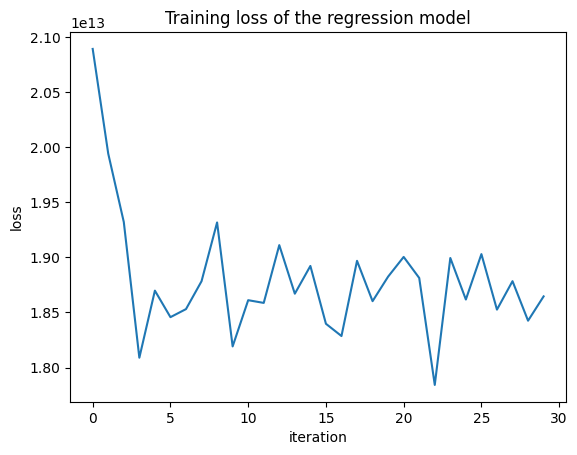

In [17]:
# plot the losses
plt.plot(losses)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Training loss of the regression model')
plt.show()

### Neural Network to predict the photovoltaic power generation with a normal distribution

In [12]:
class Net_Normal(nn.Module):
    def __init__(self, len):
        super(Net_Normal, self).__init__()  # Corrected here
        self.fc1 = nn.Linear(len, 12)
        self.fc2 = nn.Linear(12, 24)
        self.fc3 = nn.Linear(24, 2)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        mu, logvar = torch.chunk(x, 2, dim=1)
        return self.reparametrize(mu, logvar), mu, logvar


In [13]:

net = Net_Normal(len(trainset.input[0]))
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
nb_epoch = 15
losses = []


In [14]:
wandb.init(project="mlopstriplep", entity="g-delporte")
wandb.config = {
"learning_rate": lr,
"epochs": nb_epoch,
"batch_size": 4,
}

wandb.watch(net, criterion, log="all", log_freq=10)

for epoch in range(nb_epoch):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = torch.tensor(inputs, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.float32)
        
        optimizer.zero_grad()
        outputs, mu, logvar = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 2000}')
            losses.append(running_loss)
            running_loss = 0.0
    wandb.log({
        "epoch": epoch,
        "train_loss": losses[-1],
    })

wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: g-delporte. Use `wandb login --relogin` to force relogin


/tmp/ipykernel_37786/3735338263.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)
/tmp/ipykernel_37786/3735338263.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32)
/home/guilome/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1, 2000] loss: 1775860192329.4934
[1, 4000] loss: 13001406146.613874
[2, 2000] loss: 11554880152.875
[2, 4000] loss: 11259711759.248
[3, 2000] loss: 10112593824.284
[3, 4000] loss: 10525922914.136
[4, 2000] loss: 10348490153.56
[4, 4000] loss: 9527024891.144
[5, 2000] loss: 9810627964.704
[5, 4000] loss: 9440554542.8
[6, 2000] loss: 9561460105.984
[6, 4000] loss: 9166874748.784
[7, 2000] loss: 9547651180.432
[7, 4000] loss: 9078276810.88
[8, 2000] loss: 9219633196.528
[8, 4000] loss: 9168928553.344
[9, 2000] loss: 9554330579.776
[9, 4000] loss: 8923767037.64
[10, 2000] loss: 9498806350.464
[10, 4000] loss: 9247990508.608
[11, 2000] loss: 9513011331.392
[11, 4000] loss: 9121489824.544
[12, 2000] loss: 9710351279.696
[12, 4000] loss: 9030657152.928
[13, 2000] loss: 9437842378.08
[13, 4000] loss: 9341634841.568
[14, 2000] loss: 9342286968.672
[14, 4000] loss: 9759156033.936
[15, 2000] loss: 9591019968.672
[15, 4000] loss: 9177671129.664


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▅▄▂▂▁▁▁▁▂▁▁▂▂▁
epoch,14
train_loss,18355342259328.0


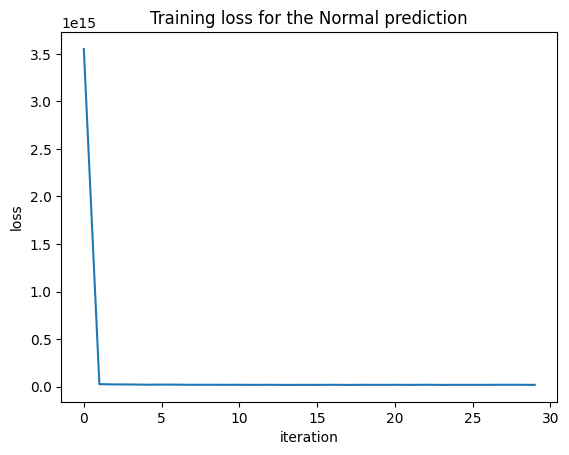

In [16]:
# plot the losses
plt.plot(losses)
plt.title('Training loss for the Normal prediction')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()